# Описание проекта

В данном задании вам предстоит осуществить путешевствие в мир Спрингфилда,
где вы сможете познакомиться со всеми любимыми персонажами Симпсонов.

Основным заданием будет обучить классификатор на основе сверточных сетей,
чтобы научиться отличать всех жителей Спрингфилда.
# Описание датасета
Обучающая и тестовая выборка состоят из отрывков из мультсериала Симпсоны.
Каждая картинка представлена в формате jpg c необходимой меткой - названием
персонажа изображенного на ней. Тест был поделен на приватную и публичную
часть в соотношении 95/5

В тренировочном датасете примерно по 1000 картинок на каждый класс,
но они отличаются размером.

Метки классов представлены в виде названий папок, в которых лежат картинки.

# Содержание:
1. [__Подготовка данных__](#data_preparation)

# <a name='data_preparation'>1. Подготовка данных</a>

In [2]:
from PIL import Image
import numpy as np
from pathlib import Path
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import DatasetFolder, ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Посмотрим на список классов
os.listdir('Data/train')

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

In [4]:
dataset = ImageFolder('Data/train/')


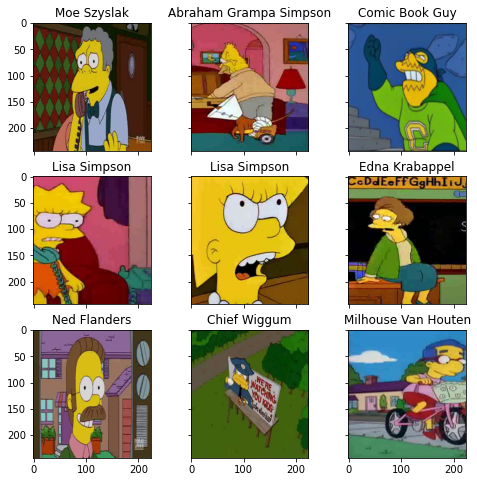

In [12]:
# Посмотрим на некоторые изображения
np.random.seed(42)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = np.random.choice(len(dataset), 1)[0]
    im, label = dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             dataset.classes[label].split('_')))
    im = im.resize((224, 244))
    fig_x.imshow(im)
    if img_label is not None:
        fig_x.set_title(img_label)
    fig_x.grid(False)

In [108]:
# Создадим загрузчик данных

class MyDataLoader:
    def __init__(self, data, indices, batch_size, shuffle=False):
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.indices = indices
        self.data = data
        self.data_len = len(indices)
        self.len_ = int(np.ceil(self.data_len / batch_size))

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min(self.data_len, start_index + self.batch_size)
        batch_indices = self.indices[start_index: end_index]
        batch = []
        for batch_index in batch_indices:
            batch.append(self.data[batch_index])
        return batch

    def __next__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        for n_batch in range(self.len_):
            return self.__getitem__(n_batch)

In [109]:
# Разделим выборки
train_val_indices, test_indices = train_test_split(np.arange(len(dataset)),
                                                   train_size=0.75)

train_indices, val_indices = train_test_split(train_val_indices,
                                              train_size=0.75)

In [111]:
# Создадим загрузчики
train_loader = MyDataLoader(dataset, train_indices, 64, True)
val_loader = MyDataLoader(dataset, val_indices, 32)
test_loader = MyDataLoader(dataset, test_indices, 32)